In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import torch
import math
import random
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import torchtuples as tt
from torchtuples import Model
from sklearn.model_selection import train_test_split
from torch import nn, Tensor
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
importr('quantreg')

from torch import nn, Tensor
from dqAux_new import dqNetSparse
from localrqgrid import lprq0g
from localrq import lprq0
from ph import ph
from bandwidthaic import bandwidthaic
from ci import cifint

In [2]:
df=pd.read_csv('E:/python_JBESRR_ci_empirical_testing_FVDCQ_robust_check/4index_daily_returns_check.csv')  #data set
daily_return=df.values
nx=np.size(daily_return,0)

In [3]:
m_t1=daily_return[0:(nx-1),5]
X=np.zeros(((nx-1),4))

for i in range(4):
    X[:,i]=daily_return[1:nx,i+1]

In [4]:
#testing data
x_ftse=X[:,0].reshape(-1,1)
x_nikk=X[:,1].reshape(-1,1)
x_sp=X[:,2].reshape(-1,1)
x_sse=X[:,3].reshape(-1,1)
Y1=x_ftse*50
Y2=x_nikk*50
Y3=x_sp*50
Y4=x_sse*50
index=m_t1*50
n=len(index)

#training data
x_ftset=X[0:int(np.floor(n*0.8)),0].reshape(-1,1)
x_nikkt=X[0:int(np.floor(n*0.8)),1].reshape(-1,1)
x_spt=X[0:int(np.floor(n*0.8)),2].reshape(-1,1)
x_sset=X[0:int(np.floor(n*0.8)),3].reshape(-1,1)
m_t1t=m_t1[0:int(np.floor(n*0.8))].reshape(-1)

Y1t=x_ftset*50
Y2t=x_nikkt*50
Y3t=x_spt*50
Y4t=x_sset*50
indext=m_t1t*50
nt=len(indext)

#validation data
x_ftsev=X[int(np.floor(n*0.8)):n,0].reshape(-1,1)
x_nikkv=X[int(np.floor(n*0.8)):n,1].reshape(-1,1)
x_spv=X[int(np.floor(n*0.8)):n,2].reshape(-1,1)
x_ssev=X[int(np.floor(n*0.8)):n,3].reshape(-1,1)
m_t1v=m_t1[int(np.floor(n*0.8)):n].reshape(-1)

Y1v=x_ftsev*50
Y2v=x_nikkv*50
Y3v=x_spv*50
Y4v=x_ssev*50
indexv=m_t1v*50
nv=len(indexv)

tau=0.05

In [7]:
 #Preliminary step
 L=int(np.floor(0.8*(n^(1/8)))
 preY=np.hstack((Y1,Y2,Y3,Y4))
 Y=np.hstack((Y1[(L+1):(n-1)],Y2[(L+1):(n-1)],Y3[(L+1):(n-1)],Y4[(L+1):(n-1)]))
 indexz=index[(L+1):(n-1)]
 kap=np.size(preY,1)
 preY11=np.zeros(((n-L-2),(kap*(L+1))))
 indexzz=np.zeros(((n-L-2),(L+1)))

 preYt=np.hstack((Y1t,Y2t,Y3t,Y4t))
 Yt=np.hstack((Y1t[(L+1):(nt-1)],Y2t[(L+1):(nt-1)],Y3t[(L+1):(nt-1)],Y4t[(L+1):(nt-1)]))
 indexzt=index[(L+1):(nt-1)]
 kap=np.size(preYt,1)
 preY11t=np.zeros(((nt-L-2),(kap*(L+1))))
 indexzzt=np.zeros(((nt-L-2),(L+1)))

 preYv=np.hstack((Y1v,Y2v,Y3v,Y4v))
 Yv=np.hstack((Y1v[(L+1):(nv-1)],Y2v[(L+1):(nv-1)],Y3v[(L+1):(nv-1)],Y4v[(L+1):(nv-1)]))
 indexzv=indexv[(L+1):(nv-1)]
 kap=np.size(preYv,1)
 preY11v=np.zeros(((nv-L-2),(kap*(L+1))))
 indexzzv=np.zeros(((nv-L-2),(L+1)))
  
 for lg in range(L+1):
    
   preY11[:,(kap*lg):(kap*(lg+1))]=np.absolute(preY[((L+1)-lg-1):(n-1-lg-1),:])
   indexzz[:,lg]=index[((L+1)-(lg)):((n-1)-(lg))].reshape(-1)

   preY11t[:,(kap*lg):(kap*(lg+1))]=np.absolute(preYt[((L+1)-lg-1):(nt-1-lg-1),:])
   indexzzt[:,lg]=indext[((L+1)-(lg)):((nt-1)-(lg))].reshape(-1)

   preY11v[:,(kap*lg):(kap*(lg+1))]=np.absolute(preYv[((L+1)-lg-1):(nv-1-lg-1),:])
   indexzzv[:,lg]=indexv[((L+1)-(lg)):((nv-1)-(lg))].reshape(-1)


In [8]:
 nm0=np.zeros((L+2,1))
 for l in range(L+1):
   nm0[(l+1)]=nm0[l]+(l+1)+kap
 nm=nm0.astype(int)

In [9]:
 x_trainin=np.zeros((nt-L-2,nm[L+1][0]))
 for ll in range(L+1):
   x_trainin[:,(nm[ll][0]):nm[(ll+1)][0]]=np.hstack((indexzzt[:,0:(ll+1)],preY11t[:,(kap*ll):(kap*(ll+1))]))

 x_testin=np.zeros((n-L-2,nm[L+1][0]))
 for ll in range(L+1):
   x_testin[:,(nm[ll][0]):nm[(ll+1)][0]]=np.hstack((indexzz[:,0:(ll+1)],preY11[:,(kap*ll):(kap*(ll+1))]))

 x_valin=np.zeros((nv-L-2,nm[L+1][0]))
 for ll in range(L+1):
   x_valin[:,(nm[ll][0]):nm[(ll+1)][0]]=np.hstack((indexzzv[:,0:(ll+1)],preY11v[:,(kap*ll):(kap*(ll+1))]))

In [10]:
 # standardize covariates
 #testing data
 Y_1=torch.tensor(Y[:,0].reshape(-1,1).astype('float32'))
 Y_2=torch.tensor(Y[:,1].reshape(-1,1).astype('float32'))
 Y_3=torch.tensor(Y[:,2].reshape(-1,1).astype('float32'))
 Y_4=torch.tensor(Y[:,3].reshape(-1,1).astype('float32'))
 indexz=torch.tensor(indexz.astype('float32'))

 preY11=torch.tensor(preY11.astype('float32'))
 indexzz=torch.tensor(indexzz.astype('float32'))
 #x_test=torch.cat((indexzz,preY11),1) 
 x_test=torch.tensor(x_testin.astype('float32'))

 #training data
 Y_1t=torch.tensor(Yt[:,0].reshape(-1,1).astype('float32'))
 Y_2t=torch.tensor(Yt[:,1].reshape(-1,1).astype('float32'))
 Y_3t=torch.tensor(Yt[:,2].reshape(-1,1).astype('float32'))
 Y_4t=torch.tensor(Yt[:,3].reshape(-1,1).astype('float32'))
 indexzt=torch.tensor(indexzt.astype('float32'))

 preY11t=torch.tensor(preY11t.astype('float32'))
 indexzzt=torch.tensor(indexzzt.astype('float32'))
 #x_train=torch.cat((indexzzt,preY11t),1) 
 x_train=torch.tensor(x_trainin.astype('float32'))

 #validation data
 Y_1v=torch.tensor(Yv[:,0].reshape(-1,1).astype('float32'))
 Y_2v=torch.tensor(Yv[:,1].reshape(-1,1).astype('float32'))
 Y_3v=torch.tensor(Yv[:,2].reshape(-1,1).astype('float32'))
 Y_4v=torch.tensor(Yv[:,3].reshape(-1,1).astype('float32'))
 indexzv=torch.tensor(indexzv.astype('float32'))

 preY11v=torch.tensor(preY11v.astype('float32'))
 indexzzv=torch.tensor(indexzzv.astype('float32'))
 #x_val=torch.cat((indexzzv,preY11v),1) 
 x_val=torch.tensor(x_valin.astype('float32'))

In [11]:
 #set random seed for replication
 def seed_torch(seed: int = 42) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)

 seed_torch()

In [12]:
 # training Quantile Regression
 #dim_nonpar=np.size(x_trainin,1)
 dim_nonpar=np.size(x_train,1)

 # hyperparameters
 nodes = [2,128] # number of network layers and nodes per layer
 lr = 0.001
 epochs = 1000
 verbose = False
 sparseRatio = 0.5

 ## loss function
 def check_loss(y_pred: Tensor, target: Tensor, tau: float) -> Tensor:
    errors = target-y_pred 
    u = torch.max(tau*errors,(tau-1)*errors)
    return u.mean()

 EPOCH = epochs

 reslist1 = []
 Train_Loss_list1 = []
 Valid_Loss_list1 = []

 Net1=dqNetSparse(dim_nonpar,nodes,sparseRatio)
 optimizer1=torch.optim.Adam(Net1.parameters(),lr=lr)

 # training step
 model_path="E:/learning_python/weights_empirical_study"

 for epoch in range(1, EPOCH + 1):

    prediction1t=Net1(x_train) 
    train_loss1 = check_loss(prediction1t,Y_1t,tau) 
    optimizer1.zero_grad() 
    train_loss1.backward() 
    optimizer1.step() 
     
    Train_Loss_list1.append(train_loss1)
    torch.save(Net1, os.path.join(model_path, 'catdogclassifi_es_1-%s.pth' % epoch))
     
    y_fval1=Net1(x_val)
    test_loss1= check_loss(y_fval1,Y_1v,tau)
    Valid_Loss_list1.append(test_loss1)
    reslist1.append(test_loss1)
    print(epoch)    

 min_num1 = min(reslist1)
 min_index1 = reslist1.index(min_num1)
 #min_num1 = min(Train_Loss_list1)
 #min_index1 = Train_Loss_list1.index(min_num1)
 print('model%s' % (min_index1 + 1))

 Netnew1=torch.load(r'E:/learning_python/weights_empirical_study/catdogclassifi_es_1-%s.pth' % (min_index1 + 1))
 sigmatile1=Netnew1(x_test).detach().numpy()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8136\1502515136.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Netnew1=torch.load(r'E:/learning_python/weights_empi

In [13]:
 ##Y_2

 reslist2 = []
 Train_Loss_list2 = []
 Valid_Loss_list2 = []

 Net2=dqNetSparse(dim_nonpar,nodes,sparseRatio)
 optimizer2=torch.optim.Adam(Net2.parameters(),lr=lr)

 # training step
 for epoch in range(1, EPOCH + 1):

    prediction2t=Net2(x_train) 
    train_loss2 = check_loss(prediction2t,Y_2t,tau) 
    optimizer2.zero_grad() 
    train_loss2.backward() 
    optimizer2.step() 
     
    Train_Loss_list2.append(train_loss2)
    torch.save(Net2, os.path.join(model_path, 'catdogclassifi_es_2-%s.pth' % epoch))
     
    y_fval2=Net2(x_val)
    test_loss2= check_loss(y_fval2,Y_2v,tau)
    Valid_Loss_list2.append(test_loss2)
    reslist2.append(test_loss2)
    print(epoch)
     
 min_num2 = min(reslist2)
 min_index2 = reslist2.index(min_num2)
 #min_num2 = min(Train_Loss_list2)
 #min_index2 = Train_Loss_list2.index(min_num2)
 print('model%s' % (min_index2 + 1))

 Netnew2=torch.load(r'E:/learning_python/weights_empirical_study/catdogclassifi_es_2-%s.pth' % (min_index2 + 1))
 sigmatile2=Netnew2(x_test).detach().numpy()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8136\2109846351.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Netnew2=torch.load(r'E:/learning_python/weights_empi

In [14]:
 ##Y_3
 reslist3 = []
 Train_Loss_list3 = []
 Valid_Loss_list3 = []

 Net3=dqNetSparse(dim_nonpar,nodes,sparseRatio)
 optimizer3=torch.optim.Adam(Net3.parameters(),lr=lr)

 # training step
 for epoch in range(1, EPOCH + 1):

    prediction3t=Net3(x_train) 
    train_loss3 = check_loss(prediction3t,Y_3t,tau) 
    optimizer3.zero_grad() 
    train_loss3.backward() 
    optimizer3.step() 

    Train_Loss_list3.append(train_loss3)
    torch.save(Net3, os.path.join(model_path, 'catdogclassifi_es_3-%s.pth' % epoch))
     
    y_fval3=Net3(x_val)
    test_loss3= check_loss(y_fval3,Y_3v,tau)
    Valid_Loss_list3.append(test_loss3)
    reslist3.append(test_loss3)
     
    print(epoch)
     
 min_num3 = min(reslist3)
 min_index3 = reslist3.index(min_num3)
 #min_num3 = min(Train_Loss_list3)
 #min_index3 = Train_Loss_list3.index(min_num3)
 print('model%s' % (min_index3 + 1))

 Netnew3=torch.load(r'E:/learning_python/weights_empirical_study/catdogclassifi_es_3-%s.pth' % (min_index3 + 1))
 sigmatile3=Netnew3(x_test).detach().numpy()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8136\3644199660.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Netnew3=torch.load(r'E:/learning_python/weights_empi

In [15]:
 ##Y_4
 reslist4 = []
 Train_Loss_list4 = []
 Valid_Loss_list4 = []

 Net4=dqNetSparse(dim_nonpar,nodes,sparseRatio)
 optimizer4=torch.optim.Adam(Net4.parameters(),lr=lr)

 # training step
 for epoch in range(1, EPOCH + 1):

    prediction4t=Net4(x_train) 
    train_loss4 = check_loss(prediction4t,Y_4t,tau) 
    optimizer4.zero_grad() 
    train_loss4.backward() 
    optimizer4.step()     

    Train_Loss_list4.append(train_loss4)
    torch.save(Net4, os.path.join(model_path, 'catdogclassifi_es_4-%s.pth' % epoch))
     
    y_fval4=Net4(x_val)
    test_loss4= check_loss(y_fval4,Y_4v,tau)
    Valid_Loss_list4.append(test_loss4)
    reslist4.append(test_loss4)
    print(epoch)
     
 min_num4 = min(reslist4)
 min_index4 = reslist4.index(min_num4)
 #min_num4 = min(Train_Loss_list4)
 #min_index4 = Train_Loss_list4.index(min_num4)
 print('model%s' % (min_index4 + 1))

 Netnew4=torch.load(r'E:/learning_python/weights_empirical_study/catdogclassifi_es_4-%s.pth' % (min_index4 + 1))
 sigmatile4=Netnew4(x_test).detach().numpy()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8136\1425286918.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Netnew4=torch.load(r'E:/learning_python/weights_empi

In [16]:
min_index1 + 1

36

In [17]:
min_index2 + 1

17

In [18]:
min_index3 + 1

28

In [19]:
min_index4 + 1

18

In [20]:
sigmatile=np.hstack((sigmatile1,sigmatile2,sigmatile3,sigmatile4))

In [21]:
#Step 2
L1=1
Ynew=np.hstack((Y1[(L+2):n],Y2[(L+2):n],Y3[(L+2):n],Y4[(L+2):n]))
indexzz2=index[(L+2):n]
ztile1=np.hstack((sigmatile,np.absolute(Y)))
  
ymax1=np.max(Y1)
ymax2=np.max(Y2)
ymin1=np.min(Y1)
ymin2=np.min(Y2)
ymax3=np.max(Y3)
ymax4=np.max(Y4)
ymin3=np.min(Y3)
ymin4=np.min(Y4)

b11=0.2*19.17221
b12=0.5*19.17221
b21=0.2*19.41568
b22=0.5*19.41568
  
y_rangenew1=np.median(ymax1)-np.median(ymin1)
h0cnew1=np.arange(b11*((n-L-L1-1)**-0.2),b12*((n-L-L1-1)**-0.2),0.2)
y_rangenew2=np.median(ymax2)-np.median(ymin2)
h0cnew2=np.arange(b21*((n-L-L1-1)**-0.2),b22*((n-L-L1-1)**-0.2),0.2)
nh1=len(h0cnew1)
nh2=len(h0cnew2)
#aicval1=np.zeros(nh1)
#aicval2=np.zeros(nh2)
#aicval3=np.zeros(nh1)
#aicval4=np.zeros(nh2)

In [22]:
#for kk1 in range(nh1):
   #aic,RSSm=bandwidthaic(Ynew[:,0],ztile1,tau,h0cnew1[kk1],indexzz2,indexzz2)
   #aicval1[kk1]=aic
   #print(kk1)

In [23]:
#ind5=np.argmin(aicval1)
#hpf5=h0cnew1[ind5]  
#hpf5
hpf5=1.3609900333557569

In [24]:
#for kk2 in range(nh2):
   #aic,RSSm=bandwidthaic(Ynew[:,1],ztile1,tau,h0cnew2[kk2],indexzz2,indexzz2)
   #aicval2[kk2]=aic
   #print(kk2)

In [25]:
#ind6=np.argmin(aicval2)
#hpf6=h0cnew2[ind6]
#hpf6
hpf6=1.0706539293500692

In [26]:
#for kk3 in range(nh1):
   #aic,RSSm=bandwidthaic(Ynew[:,2],ztile1,tau,h0cnew1[kk3],indexzz2,indexzz2)
   #aicval3[kk3]=aic
   #print(kk3)

In [27]:
#ind7=np.argmin(aicval3)
#hpf7=h0cnew1[ind7]  
#hpf7
hpf7=1.2609900333557569

In [28]:
#for kk4 in range(nh2):
   #aic,RSSm=bandwidthaic(Ynew[:,3],ztile1,tau,h0cnew2[kk4],indexzz2,indexzz2)
   #aicval4[kk4]=aic
   #print(kk4)

In [29]:
#ind8=np.argmin(aicval4)
#hpf8=h0cnew2[ind8]
#hpf8
hpf8=1.0706539293500692

In [30]:
grid=np.arange(-1,1.1,0.1)
gn=len(grid)

In [31]:
fv, dv, w0 = lprq0g(Ynew[:,0], ztile1, hpf5, tau, indexzz2, grid)
ainfinal1=fv
fv, dv, w0 = lprq0g(Ynew[:,1], ztile1, hpf6, tau, indexzz2, grid)
ainfinal2=fv
  
fv, dv, w0 = lprq0g(Ynew[:,2], ztile1, hpf7, tau, indexzz2, grid)
ainfinal3=fv
fv, dv, w0 = lprq0g(Ynew[:,3], ztile1, hpf8, tau, indexzz2, grid)
ainfinal4=fv

In [32]:
#Confidence interval
#CI1
uerror,lerror=cifint(Ynew[:,0],ztile1,ainfinal1,hpf5,tau,indexzz2,grid)
uerror1=uerror
lerror1=lerror
  
ainfadj1=ainfinal1
upper1=ainfadj1+uerror1
lower1=ainfadj1+lerror1

In [33]:
#CI2
uerror,lerror=cifint(Ynew[:,1],ztile1,ainfinal2,hpf6,tau,indexzz2,grid)
uerror2=uerror
lerror2=lerror
  
ainfadj2=ainfinal2
upper2=ainfadj2+uerror2
lower2=ainfadj2+lerror2

In [34]:
#CI3
uerror,lerror=cifint(Ynew[:,2],ztile1,ainfinal3,hpf7,tau,indexzz2,grid)
uerror3=uerror
lerror3=lerror
  
ainfadj3=ainfinal3
upper3=ainfadj3+uerror3
lower3=ainfadj3+lerror3  

In [35]:
#CI4
uerror,lerror=cifint(Ynew[:,3],ztile1,ainfinal4,hpf8,tau,indexzz2,grid)
uerror4=uerror
lerror4=lerror
  
ainfadj4=ainfinal4
upper4=ainfadj4+uerror4
lower4=ainfadj4+lerror4

In [36]:
#varying-coefficients and confidence intervals

ainfinal=np.zeros((gn,4,4))
ufinal=np.zeros((gn,4,4))
lfinal=np.zeros((gn,4,4))

for g in range(gn):
  
  inainfinal=np.stack((ainfadj1[g,1:5],ainfadj2[g,1:5],ainfadj3[g,1:5],ainfadj4[g,1:5]))
  ainfinal[g,:,:]=inainfinal
  inufinal=np.stack((upper1[g,1:5],upper2[g,1:5],upper3[g,1:5],upper4[g,1:5]))
  ufinal[g,:,:]=inufinal
  inlfinal=np.stack((lower1[g,1:5],lower2[g,1:5],lower3[g,1:5],lower4[g,1:5]))
  lfinal[g,:,:]=inlfinal

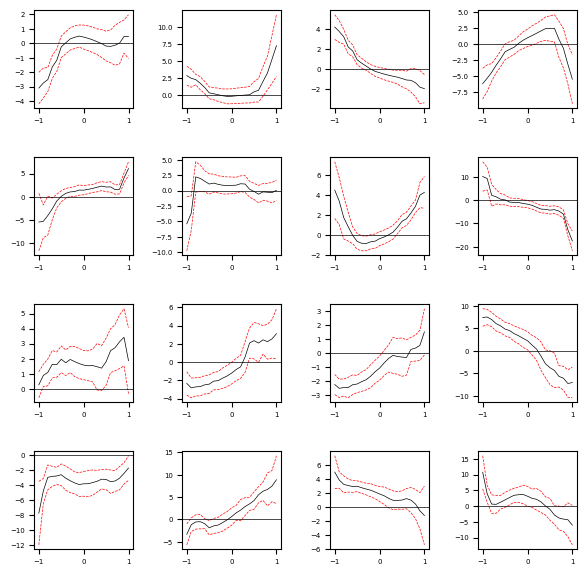

In [37]:
plt.figure(figsize=(7,7))

plt.subplot(4,4,1)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,0,0],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,0,0],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,0,0],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,2)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,0,1],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,0,1],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,0,1],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,3)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,0,2],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,0,2],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,0,2],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,4)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,0,3],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,0,3],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,0,3],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,5)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,1,0],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,1,0],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,1,0],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,6)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,1,1],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,1,1],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,1,1],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,7)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,1,2],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,1,2],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,1,2],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,8)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,1,3],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,1,3],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,1,3],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,9)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,2,0],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,2,0],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,2,0],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,10)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,2,1],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,2,1],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,2,1],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,11)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,2,2],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,2,2],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,2,2],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,12)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,2,3],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,2,3],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,2,3],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,13)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,3,0],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,3,0],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,3,0],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,14)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,3,1],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,3,1],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,3,1],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,15)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,3,2],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,3,2],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,3,2],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplot(4,4,16)
plt.tick_params(labelsize=5)
plt.plot(grid,ainfinal[:,3,3],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ufinal[:,3,3],color='r',linewidth=0.5,linestyle='--') 
plt.plot(grid,lfinal[:,3,3],color='r',linewidth=0.5,linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [38]:
#in and out
DI=grid
gn=len(DI)

outFTSE100=(np.absolute(ainfinal1[:,1])+np.absolute(ainfinal2[:,1])+np.absolute(ainfinal3[:,1])+np.absolute(ainfinal4[:,1]))
inFTSE100=(np.absolute(ainfinal1[:,1])+np.absolute(ainfinal1[:,2])+np.absolute(ainfinal1[:,3])+np.absolute(ainfinal1[:,4]))
outNikkei225=(np.absolute(ainfinal1[:,2])+np.absolute(ainfinal2[:,2])+np.absolute(ainfinal3[:,2])+np.absolute(ainfinal4[:,2]))
inNikkei225=(np.absolute(ainfinal2[:,1])+np.absolute(ainfinal2[:,2])+np.absolute(ainfinal2[:,3])+np.absolute(ainfinal2[:,4]))
outSP500=(np.absolute(ainfinal1[:,3])+np.absolute(ainfinal2[:,3])+np.absolute(ainfinal3[:,3])+np.absolute(ainfinal4[:,3]))
inSP500=(np.absolute(ainfinal3[:,1])+np.absolute(ainfinal3[:,2])+np.absolute(ainfinal3[:,3])+np.absolute(ainfinal3[:,4]))
outSSE=(np.absolute(ainfinal1[:,4])+np.absolute(ainfinal2[:,4])+np.absolute(ainfinal3[:,4])+np.absolute(ainfinal4[:,4]))
inSSE=(np.absolute(ainfinal4[:,1])+np.absolute(ainfinal4[:,2])+np.absolute(ainfinal4[:,3])+np.absolute(ainfinal4[:,4]))

ainfinal=np.zeros((gn,2,4))

for g in range(gn):
  
  outain=np.hstack((outFTSE100[g],outNikkei225[g],outSP500[g],outSSE[g]))
  inain=np.hstack((inFTSE100[g],inNikkei225[g],inSP500[g],inSSE[g]))
  inainfinal=np.stack((outain,inain))
  ainfinal[g,:,:]=inainfinal

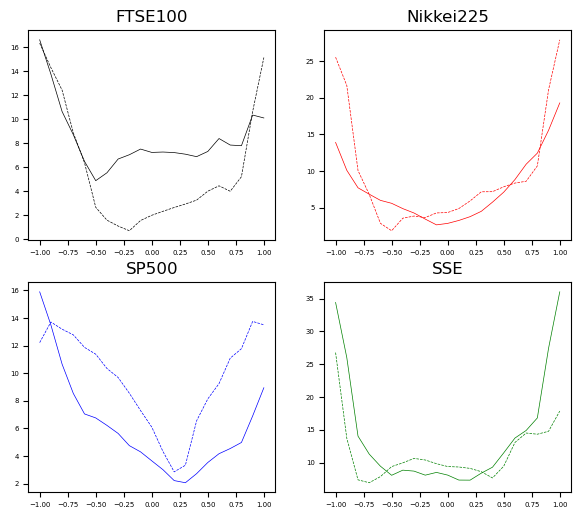

In [39]:
plt.figure(figsize=(7,6))

plt.subplot(2,2,1)
plt.tick_params(labelsize=5)
plt.title('FTSE100')
plt.plot(grid,ainfinal[:,0,0],color='k',linewidth=0.5,linestyle='-') 
plt.plot(grid,ainfinal[:,1,0],color='k',linewidth=0.5,linestyle='--') 

plt.subplot(2,2,2)
plt.tick_params(labelsize=5)
plt.title('Nikkei225')
plt.plot(grid,ainfinal[:,0,1],color='r',linewidth=0.5,linestyle='-') 
plt.plot(grid,ainfinal[:,1,1],color='r',linewidth=0.5,linestyle='--') 

plt.subplot(2,2,3)
plt.tick_params(labelsize=5)
plt.title('SP500')
plt.plot(grid,ainfinal[:,0,2],color='b',linewidth=0.5,linestyle='-') 
plt.plot(grid,ainfinal[:,1,2],color='b',linewidth=0.5,linestyle='--') 

plt.subplot(2,2,4)
plt.tick_params(labelsize=5)
plt.title('SSE')
plt.plot(grid,ainfinal[:,0,3],color='g',linewidth=0.5,linestyle='-') 
plt.plot(grid,ainfinal[:,1,3],color='g',linewidth=0.5,linestyle='--') 

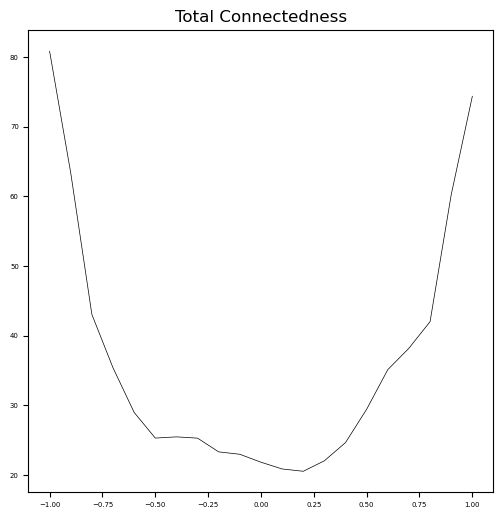

In [40]:
#Out+in degree
DI_t=grid

FTSE100=np.absolute(ainfinal1[:,1])+np.absolute(ainfinal1[:,2])+np.absolute(ainfinal1[:,3])+np.absolute(ainfinal1[:,4])
Nikkei225=np.absolute(ainfinal2[:,1])+np.absolute(ainfinal2[:,2])+np.absolute(ainfinal2[:,3])+np.absolute(ainfinal2[:,4])
SP500=np.absolute(ainfinal3[:,1])+np.absolute(ainfinal3[:,2])+np.absolute(ainfinal3[:,3])+np.absolute(ainfinal3[:,4])
SSE=np.absolute(ainfinal4[:,1])+np.absolute(ainfinal4[:,2])+np.absolute(ainfinal4[:,3])+np.absolute(ainfinal4[:,4])
Total_connectedness=FTSE100+Nikkei225+SP500+SSE

plt.figure(figsize=(6,6))
plt.tick_params(labelsize=5)
plt.title('Total Connectedness')
plt.plot(grid,Total_connectedness,color='k',linewidth=0.5,linestyle='-') 